# `stitches` quickstart

The purpose of this tutorial is to demonstrate how `stitches` can be used as an
emulator. While `stitches` can  emulate a number of CMIP6 models, this example
 will focus on emulating CanESM5 SSP245 results.

This tutorial also assumes that the user has either seen a talk on `stitches` or
read the paper published in _Earth System Dyanmics_ (Tebaldi et al 2022). This
tutorial is aimed at highlighting the flexibility of functions in `stitches`.
All notebooks assume a familiarity with CMIP-style data.

To use `stitches`, there are a number of decisions users have to make,
perhaps the most important being:

* Which ESM (singluar) will `stitches` emulate?
* What _archive data_ will be used? These are values of global temperature (in the
following referred to as GSAT, or Tgav, or tas) for experiments/time periods (e.g.,
historical and SSP realizations) that the target data will be matched to. It should
only contain data for the specific ESM that is being emulated.
* What _target data_ will be used? This data frame represents the temperature
pathway the stitched product will follow. The contents of this data frame may
come from computing GSAT from CMIP6 ESM temperature output (as we do in this
tutorial)  according to a standard  SSP scenario,  or it may follow some alternate
pathway that a simple model like Hector or FaIR has produced.

A diagram illustrating the `stitches` process is included for reference:

![stitches workflow](figs/stitches_diagram.jpg)

- `stitches` defaults to $X=9$ year windows.


STITCHES works by matching X-year segments of a target GSAT
trajectory to X-year segments of available GSAT trajectories, computed from the
archived output of an ESM that has been run according to SSP scenarios.

The
choice of X balances the need to maintain temporal consistency with the need to
have flexibility in matching GSAT anomalies and rates of change. STITCHES uses
 X=9 year windows.

So, if one were to take ESM data for many scenarios and plot the corresponding
 global average temperature trajectories after smoothing, the vertical lines drawn
 here represents a potential segmenting of the data into those 9-year windows of
  both available simulations (colored lines) and a target trajectory (the back line,
  here as an example, the new trajectory intermediate to those available).

![Example Tgav](figs/Tutorial_2023_tgavex.jpg)


For each segment, the median temperature value and the change in value per
segment can be plotted in a two-dimensional space where now the windows of
the available scenarios are the colored dots, and those of the target scenario are
the black dots:

![Example T, dT](figs/Tutorial_2023_T_dT_example.jpg)

This two dimensional space is where matching between target points (black) and
available archive points (colorful) occurs, using a nearest neighbor approach.


# Getting Started


In [1]:
import stitches


Load the additional python libraries that will be used in this example.
These packages are installed as `stitches` dependencies.

In [2]:
import os
import pkg_resources
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt



# For help with plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6


# Install the package data from Zenodo

The package data is all data that has been processed from raw Pangeo data
and is generated with package functions. For convenience and rapid cloning
of the github repository, the package data is also minted on Zenodo and
can be quickly downloaded for using the package. Downloading and unzipping
the pre-processed package data takes 5-10 minutes.


The package data is generated by `stitches.generate_package_data.generate_pkg_data()`
and contains the following key items:

1. the `tas-data` directory, containing global average temperature anomalies
relative to 1995-2014 average for every available CMIP6/ScenarioMIP data set.
These GSAT time series are the primary quantity that `stitches` operates on for
matching to stitch together new realizations of gridded, multivariate NetCDF data.
The time series are calculated directly from pangeo-hosted NetCDF files with
`stitches.make_tas_archive.make_tas_archive()`. This step is quite time consuming
(2-8 hours depending on internet connection) but it only must be performed when
there have been updates to the pangeo data sets, which are rare. That is why we
have pre-processed these time series and included them as package data.

- These are also the data that `stitches.fx_stitch.gmat_stitching()` utilizes, for
when one only wants to stitch new global average temperature time series
- The time series are also the data set upon which the 'windows' and 'chunks'
mentioned above are created from, with
`stitches.make_matching_archive.make_matching_archive()`.

2. `matching_archive.csv`, `matching_archive_staggered.csv` files are the outputs of
`stitches.make_matching_archive.make_matching_archive()`. These are the critical
"archive" dataframes that `stitches` actually performs stitching on. The files
contain time window information, median temperature and temperature rate of change
for every CMIP6/ScenarioMIP data set. `matching_archive.csv` contains only windows
starting in 1850, 1859, 1868, ...; `matching_archive_staggered.csv` contains every
9 year window possible, e.g. starting at 1850, 1851, 1851... Selecting which
set of these 9 years windows to include in an archive is discussed further below.

3. `pangeo_table.csv`, the catalog information for every file pangeo hosts,
fetched directly from pangeo with a call to
`stitches.fx_pangeo.fetch_pangeo_table()`. This table is rarely updated in practice.
The `stitches` code does expect field names as they presently appear in the
pangeo table format. This will be updated in the future as new eras of CMIP
become available.


4. Example stitched temperature and precipitation NetCDF files.


*In general, we do not recommend re-generating the package data; it does have to
be done when adjusting the $X$ hyperparameter mentioned above, but this is an
untested, advanced use case that we recommend collaborating with the `stitches`
team for.*


**NOTE THAT IF YOU ARE INTERESTED IN CHANGING THE REFERENCE PERIOD from
1995-2014, it is not necessary to re-generate package data. Novel target
GSAT anomalies relative to the average over different years $startYr-endYr$
can simply be pre-adjusted to 1995-2014 before smoothing and chunking to
be targets (example below). NetCDF outputs from `stitches` are
the native ESM data, not shifted in only way. GSAT time series outputs from
`stitches` can similarly be shifted to be anomalies from $startYr-endYr$ in
post-processing.**

In [3]:
stitches.install_package_data()

Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/matching_archive.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_comparison_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/matching_archive_staggered.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/NorESM2-LM_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/NorESM2-MM_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/BCC-ESM1_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/CESM2-FV2_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/d



# Example Set Up

We will use `stitches` to emulate CanESM5 SSP245 results (an
experiment run under CMIP6). This is our _Target Data_.

Then we will compare the
`stitches` results with actual CanESM5 SSP245 output data.

For CMIP6 results, Earth system model data runs from 1850-2100 (or 2099,
depending on the ESM). This tutorial will focus on emulating that entire period.


# Decide on the target data

- The primary input to `stitches` functions that most users will adjust is the
target data.

- The target data is the temperature pathway the stitched (emulated) product
will follow. This data can come from an ESM or another class of climate models,
for a specific SSP scenario or an arbitrarily defined scenario.

- Similarly to the archive
data, the target data should contain the mean temperature anomaly and rate of
temperature change  for every X-year window into which the target GSAT
trajectory has been subdivided. `stitches` includes functions for
processing raw ESM  Tgav data into the structure it needs for matching.


In [4]:
# Load time series and subset to target time series if needed:
data_directory = pkg_resources.resource_filename('stitches', "data")
targ = pd.read_csv(os.path.join(data_directory, "tas-data", "CanESM5_tas.csv"))
target_data = targ.loc[(targ["model"] == "CanESM5")
                       & (targ["experiment"] == 'ssp245')].copy()

target_data  = target_data[target_data["ensemble"].isin(['r1i1p1f1'])].copy()

target_data = target_data.drop(columns='zstore').reset_index(drop=True)

Take a look at the structure and a plot of the time series we will be targeting:

  variable experiment  ensemble    model  year     value
0      tas     ssp245  r1i1p1f1  CanESM5  1850 -1.133884
1      tas     ssp245  r1i1p1f1  CanESM5  1851 -1.389375
2      tas     ssp245  r1i1p1f1  CanESM5  1852 -1.318175
3      tas     ssp245  r1i1p1f1  CanESM5  1853 -1.163771
4      tas     ssp245  r1i1p1f1  CanESM5  1854 -1.302066


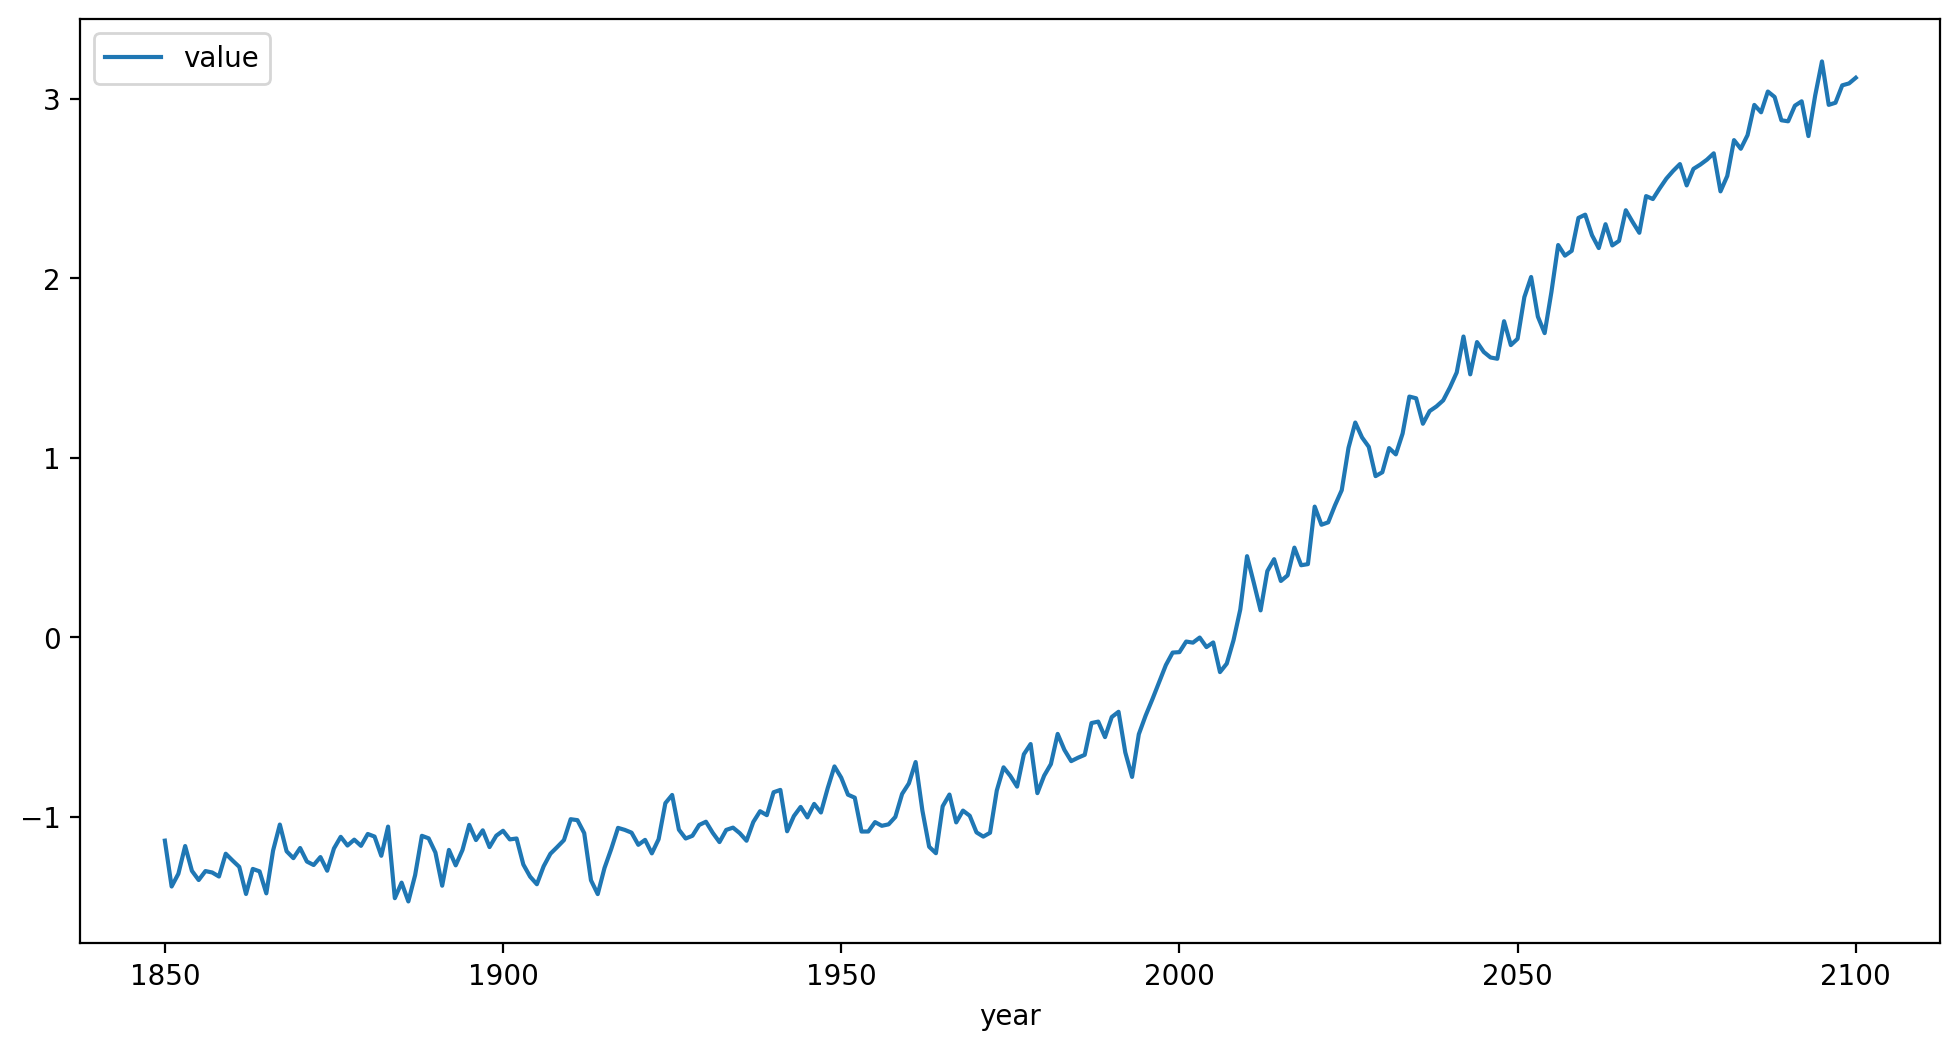

In [5]:
print(target_data.head())
target_data.plot(x='year', y='value')
plt.show()
plt.close()

- Critically, these time series are _global average temperature anomaly from
1995-2014 average_.

- In this demonstration, we will specifically be targeting ensemble member 1
of the CanESM5 SSP245 simulations. The entire SSP245 ensemble may be
jointly targeted by omitting the line
`target_data  = target_data[target_data["ensemble"].isin(['r1i1p1f1'])].copy()`

# Decide on the archive data

- Limit the archive matching data (`matching_archive.csv` or
`matching_archive_staggered.csv` package data) to the model
(singular) we are trying to emulate, CanESM5 in this case.

- In this example, we treat SSP245 as a novel scenario rather than one
run by the ESM and available, so we exclude it from the archive data.

- `stitches` actually provides two files in its pacakge data.
- `matching_archive.csv` can be considered the default (for now). Starting in
1850, nine year windows are sliced forward and don't overlap.
- The final window ends up beginning in 2093, and is only 8 years long to
terminate in 2100 (7 years if the ESM ends in 2099). `stitches` can handle
this particular type of 'short' window.

This training will demonstrate the more flexible archive setting options.
- `stitches` includes `matching_archive_staggered.csv` as package
data as well. The difference is that this file does every possible full 9-year chunk,
not just slicing sequentially from the starting point.


In [6]:
# read in the package data of all ESMs-Scenarios-ensemble members avail.
data_directory = pkg_resources.resource_filename('stitches', "data")
path = os.path.join(data_directory, 'matching_archive_staggered.csv')
data = pd.read_csv(path)

staggered_archive = data.copy()

end_yr_vector = [1858, 1866, 1875,1884, 1893,
                 1902, 1911, 1920, 1929, 1938, 1947,
                 1956,  1965, 1974, 1983, 1992, 2001,
                 2010, 2019, 2028, 2037, 2046, 2055,
                 2064, 2073, 2082, 2091, 2100]

tmp = staggered_archive.loc[(data["experiment"].isin(['ssp126', 'ssp370', 'ssp585']))
                       & (data["model"] == "CanESM5")].copy()

archive_data = stitches.fx_processing.subset_archive(staggered_archive = tmp,
                              end_yr_vector = end_yr_vector)

print(archive_data)

     experiment variable    model   ensemble  start_yr  end_yr  year  \
0        ssp126      tas  CanESM5  r10i1p1f1      1850    1858  1854   
1        ssp126      tas  CanESM5  r11i1p1f1      1850    1858  1854   
2        ssp126      tas  CanESM5  r12i1p1f1      1850    1858  1854   
3        ssp126      tas  CanESM5  r13i1p1f1      1850    1858  1854   
4        ssp126      tas  CanESM5  r14i1p1f1      1850    1858  1854   
...         ...      ...      ...        ...       ...     ...   ...   
2095     ssp585      tas  CanESM5   r9i1p1f1      2056    2064  2060   
2096     ssp585      tas  CanESM5   r9i1p1f1      2065    2073  2069   
2097     ssp585      tas  CanESM5   r9i1p1f1      2074    2082  2078   
2098     ssp585      tas  CanESM5   r9i1p1f1      2083    2091  2087   
2099     ssp585      tas  CanESM5   r9i1p1f1      2092    2100  2096   

            fx        dx  
0    -1.360399  0.016472  
1    -1.235783 -0.013422  
2    -1.378939  0.017703  
3    -1.390443  0.014038  




# Target data pre-processing
- We had decided to target SSP245 realization 1 to emulate

- The first step of pre-processing any target data is to smooth it.

In [7]:
target_data = stitches.fx_processing.calculate_rolling_mean(target_data,
                                                            size=31).copy()

For consistency with how we pre-processed the archive, we will have  the target
window ending in 2100 be a complete 9 years and work back.

You can use the `base_chunk=8` argument to do that.
`base_chunk=8` means the target starts in 1850+8 = 1858 and cuts every 9
years after that, ending in 2100.


In [8]:
target_data = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=9,
                                    base_chunk=8)).copy()
print(target_data)

    ensemble variable experiment    model  start_yr  end_yr  year        fx  \
0   r1i1p1f1      tas     ssp245  CanESM5      1858    1866  1862 -1.254450   
1   r1i1p1f1      tas     ssp245  CanESM5      1867    1875  1871 -1.242954   
2   r1i1p1f1      tas     ssp245  CanESM5      1876    1884  1880 -1.214581   
3   r1i1p1f1      tas     ssp245  CanESM5      1885    1893  1889 -1.195424   
4   r1i1p1f1      tas     ssp245  CanESM5      1894    1902  1898 -1.200969   
5   r1i1p1f1      tas     ssp245  CanESM5      1903    1911  1907 -1.172773   
6   r1i1p1f1      tas     ssp245  CanESM5      1912    1920  1916 -1.145221   
7   r1i1p1f1      tas     ssp245  CanESM5      1921    1929  1925 -1.091947   
8   r1i1p1f1      tas     ssp245  CanESM5      1930    1938  1934 -1.022043   
9   r1i1p1f1      tas     ssp245  CanESM5      1939    1947  1943 -0.994382   
10  r1i1p1f1      tas     ssp245  CanESM5      1948    1956  1952 -0.955606   
11  r1i1p1f1      tas     ssp245  CanESM5      1957 

# Emulate

This occurs with two functions:
- `stitches.make_recipe()` does the matching between a target and archive,
and gives the pointers to all of the pangeo-hosted netcdf files of data.
- `stitches.gmat_stitching()` or `stitches.gridded_stitching()` then stitch either
global average temperature anomaly  trajectories or gridded, multivariate netcdfs
from those recipes.

# Matching and making the recipe.
The arguments for making recipes are relatively simple. You specify the
target data, the archive data, how many matches you want to try to make for
each realization of the target data, and whether you want your results to be
reproducible.

Two other optional variables include
- `non_tas_variables` - which variables in addition to tas do you think you want to
have gridded results for? The default is to only provide tas recipes.
- `res` - do you want to stitch monthly (`'mon'`) or daily (`'day'`) gridded
results? The default is to monthly as daily files are very large to work with and
create.

The remaining argument, `tol` specifies the matching tolerance - for each target
window, how far out away in the archive are we willing to look for similar points?
- `stitches` prioritizes providing a nearest neighbor match, which dictates how it
currently uses `tol`
- `tol=0.0` corresponds to providing the nearest neighbor match.
- Each target window gets its own, custom nearest neighbor match that is some
distance away, `dist_nn`.
- For each target window, we center a circular matching neighborhood on the
target point. In a radius of `dist_nn`, we know the nearest neighbor is the only
available point by definition.
- Therefore, we expand the matching neighborhood for each target point to
search for matches up to a distance of `dist_nn + tol` away.
- So if target window A has a nearest neighbor 0.1degC away, and `tol=0.01`,
then a circle centered on A with radius 0.11degC contains all possible matches.
If target window B has a nearest neighbor 0.05degC away, then its matching
neighborhood is a circle centered on B with a radius of 0.06degC.


- In the paper, we provide `z_cutoff` values that are 'safe' maximum tolerances
to use for every ESM examined. We will be adding more ESMs in the future.

In [9]:
# the nearest neighbor recipes
nn_recipes = stitches.make_recipe(target_data = target_data,
                                  archive_data=archive_data,
                                  tol=0.0,
                                  N_matches=4,
                                  reproducible=True)
print(nn_recipes.head())
print(nn_recipes.tail())

You have requested more recipes than possible for at least one target trajectories, returning what can
The following target windows have a nearest neighbor in T, dT space
that is more than 0.25degC away. This may or may not result in poor
matches and we recommend validation.
  target_variable target_experiment target_ensemble target_model  \
0             tas            ssp245        r1i1p1f1      CanESM5   

   target_start_yr  target_end_yr  target_year  target_fx  target_dx  \
0             2083           2091         2087   2.832238   0.012831   

  archive_experiment  ... archive_model archive_ensemble archive_start_yr  \
0             ssp370  ...       CanESM5        r17i1p1f1             2056   

   archive_end_yr  archive_year  archive_fx  archive_dx   dist_dx   dist_fx  \
0            2064          2060    2.815717    0.045724  0.263149  0.016521   

    dist_l2  
0  0.263667  

[1 rows x 21 columns]
-----------------------------------------------------------------------------

More flexible matches

In [10]:
# additional recipes
my_recipes = stitches.make_recipe(target_data = target_data,
                                  archive_data=archive_data,
                                  tol=0.05,
                                  res='mon',
                                   non_tas_variables=['pr'],
                                  N_matches=4,
                                  reproducible=True)
print(my_recipes.head())
print('-----------------------------------')
# you can take a look at one of the actual file addresses to get a sense of
# what the Pangeo file addresses look like.:
print(my_recipes['pr_file'].iloc[0])

You have requested more recipes than possible for at least one target trajectories, returning what can
  target_start_yr target_end_yr archive_experiment archive_variable  \
0            1858          1866         historical              tas   
1            1867          1875         historical              tas   
2            1876          1884         historical              tas   
3            1885          1893         historical              tas   
4            1894          1902         historical              tas   

  archive_model archive_ensemble       stitching_id archive_start_yr  \
0       CanESM5         r1i1p1f1  ssp245~r1i1p1f1~1             1858   
1       CanESM5        r25i1p1f1  ssp245~r1i1p1f1~1             1858   
2       CanESM5        r17i1p1f1  ssp245~r1i1p1f1~1             1903   
3       CanESM5         r2i1p1f1  ssp245~r1i1p1f1~1             1912   
4       CanESM5         r1i1p1f1  ssp245~r1i1p1f1~1             1903   

  archive_end_yr                     

If you wanted to include sea level pressure in addition to precipitation, you would use
`non_tas_variables=['pr', 'psl']`.


# stitching and plotting

## Nearest neighbor result
Stitch the global average temperature for the nearest neighbor result,
and see it in the context of the actual ESM data that was not used in the archive
at all.

In [11]:
stitched_global_temp = stitches.gmat_stitching(nn_recipes)

### nearest neighbor stitched realization

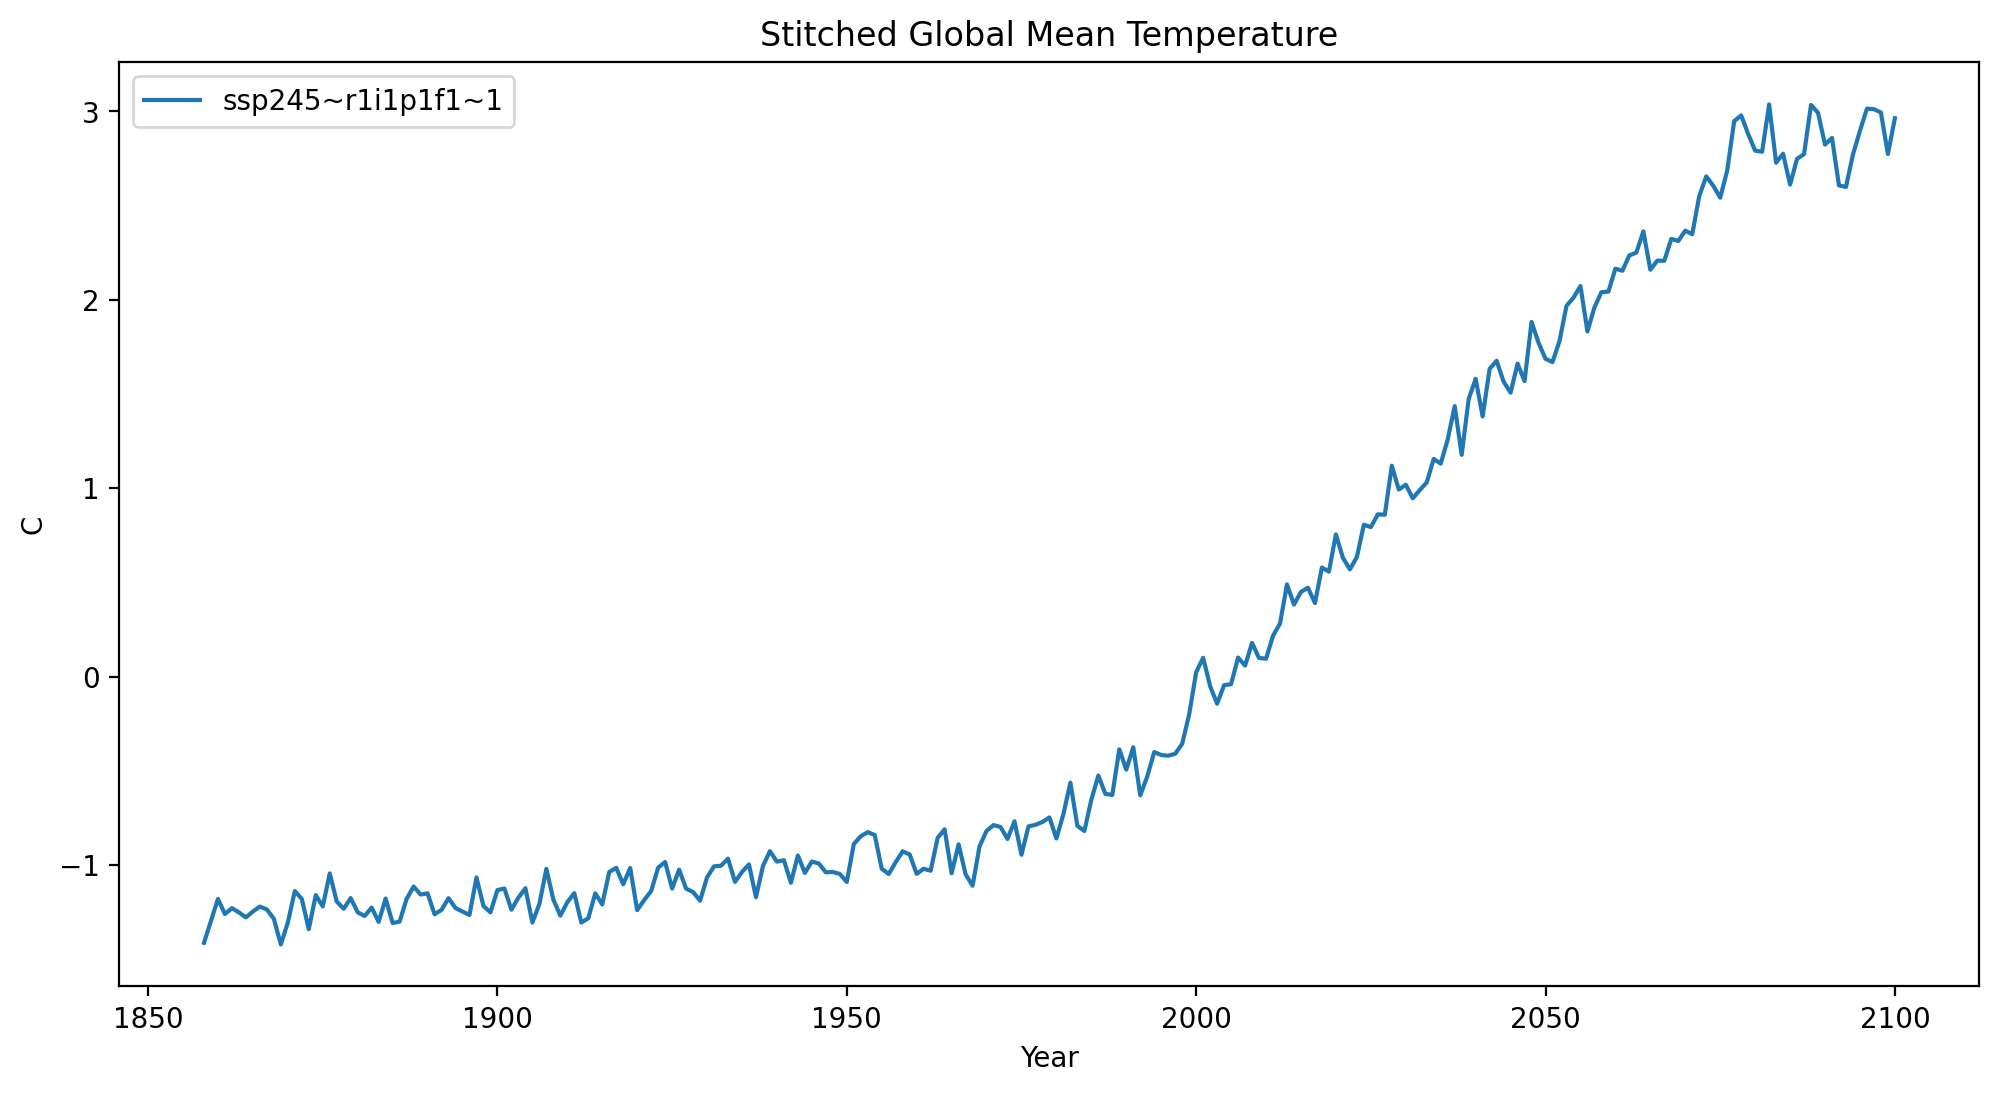

In [12]:
groups = stitched_global_temp.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature")
plt.legend()
plt.show()
plt.close()



# Load the comparison GSAT data
data_directory = pkg_resources.resource_filename("stitches", "data")
data_path = os.path.join(data_directory, "tas-data", "CanESM5_tas.csv")

comp_data = pd.read_csv(data_path)
comp_data = comp_data.loc[comp_data["experiment"] == "ssp245"]


### stitched realization and the target ensemble member

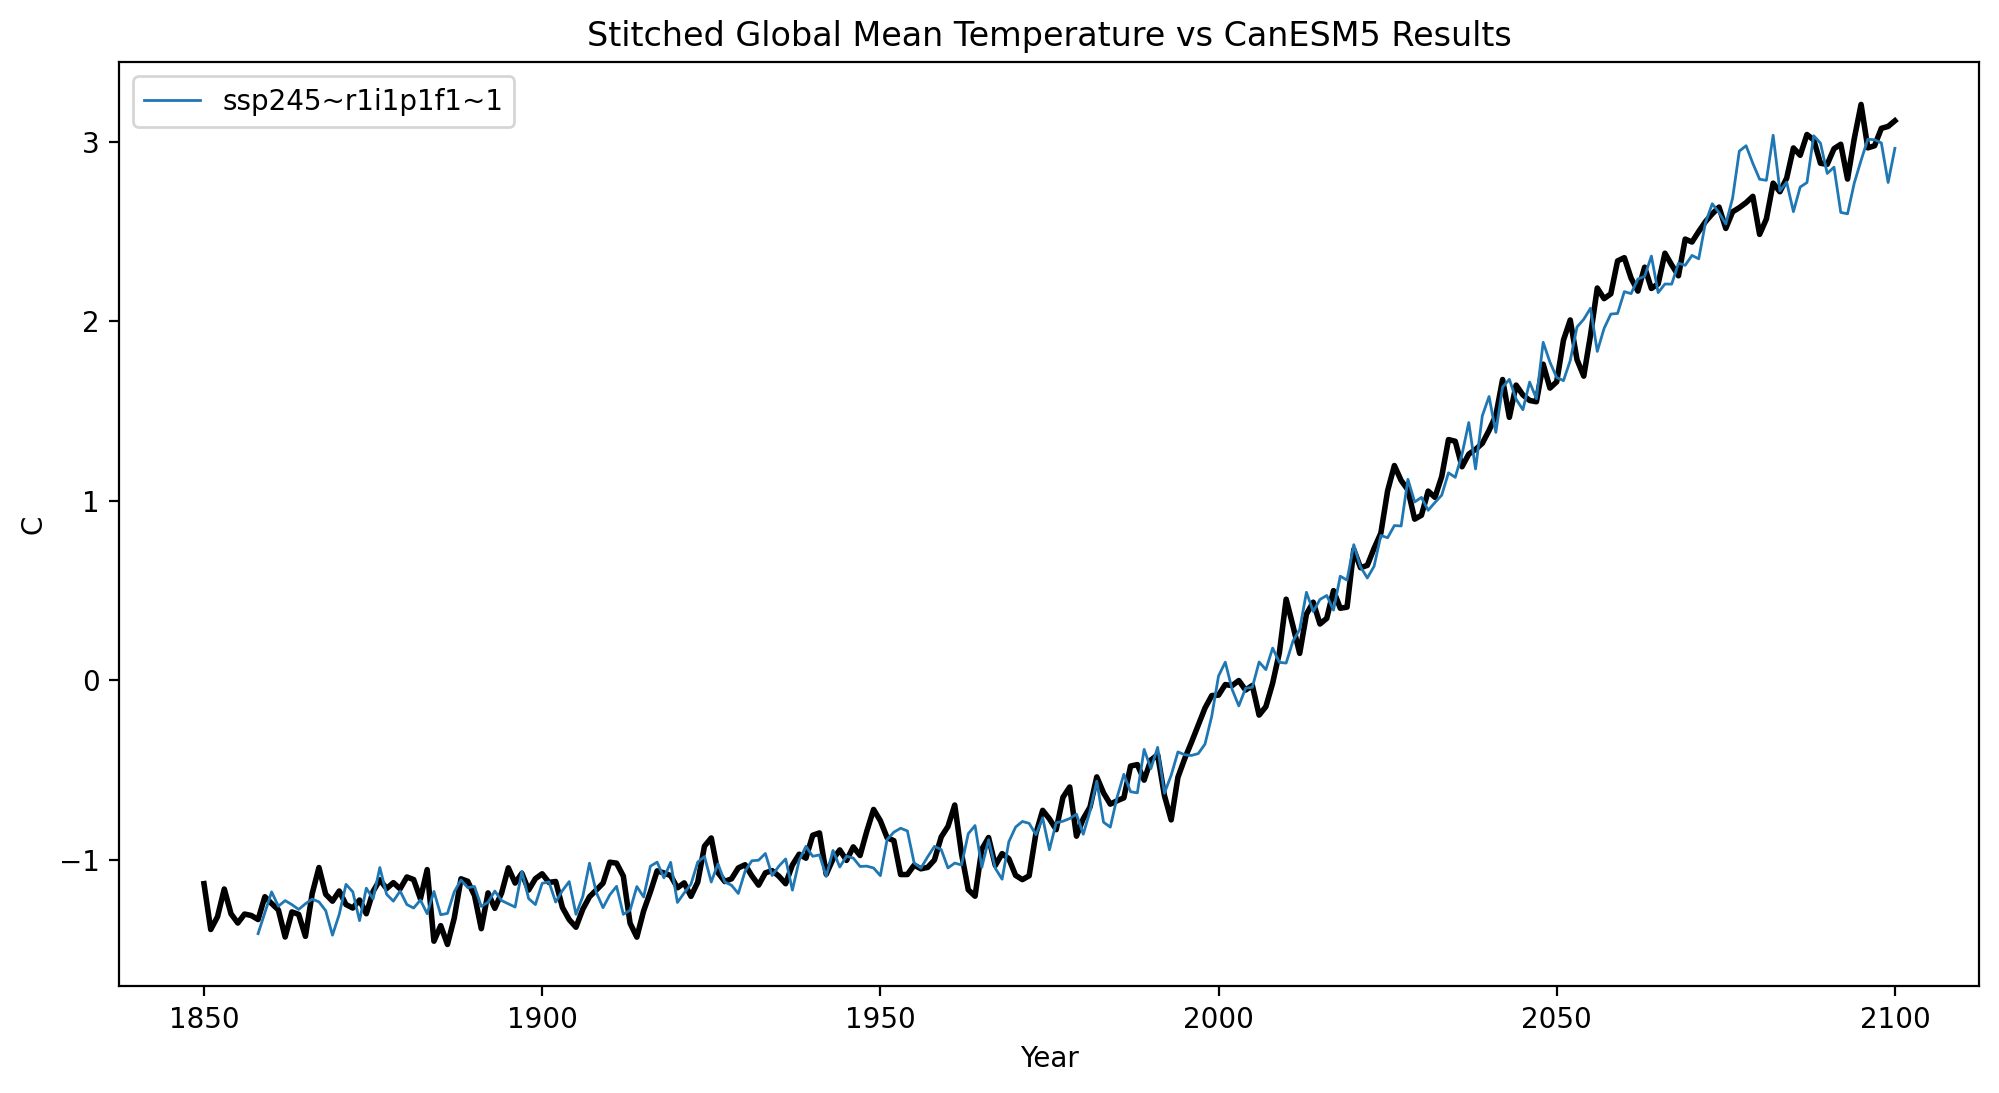

In [13]:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()
plt.close()

### stitched realization and the entire scenario ensemble

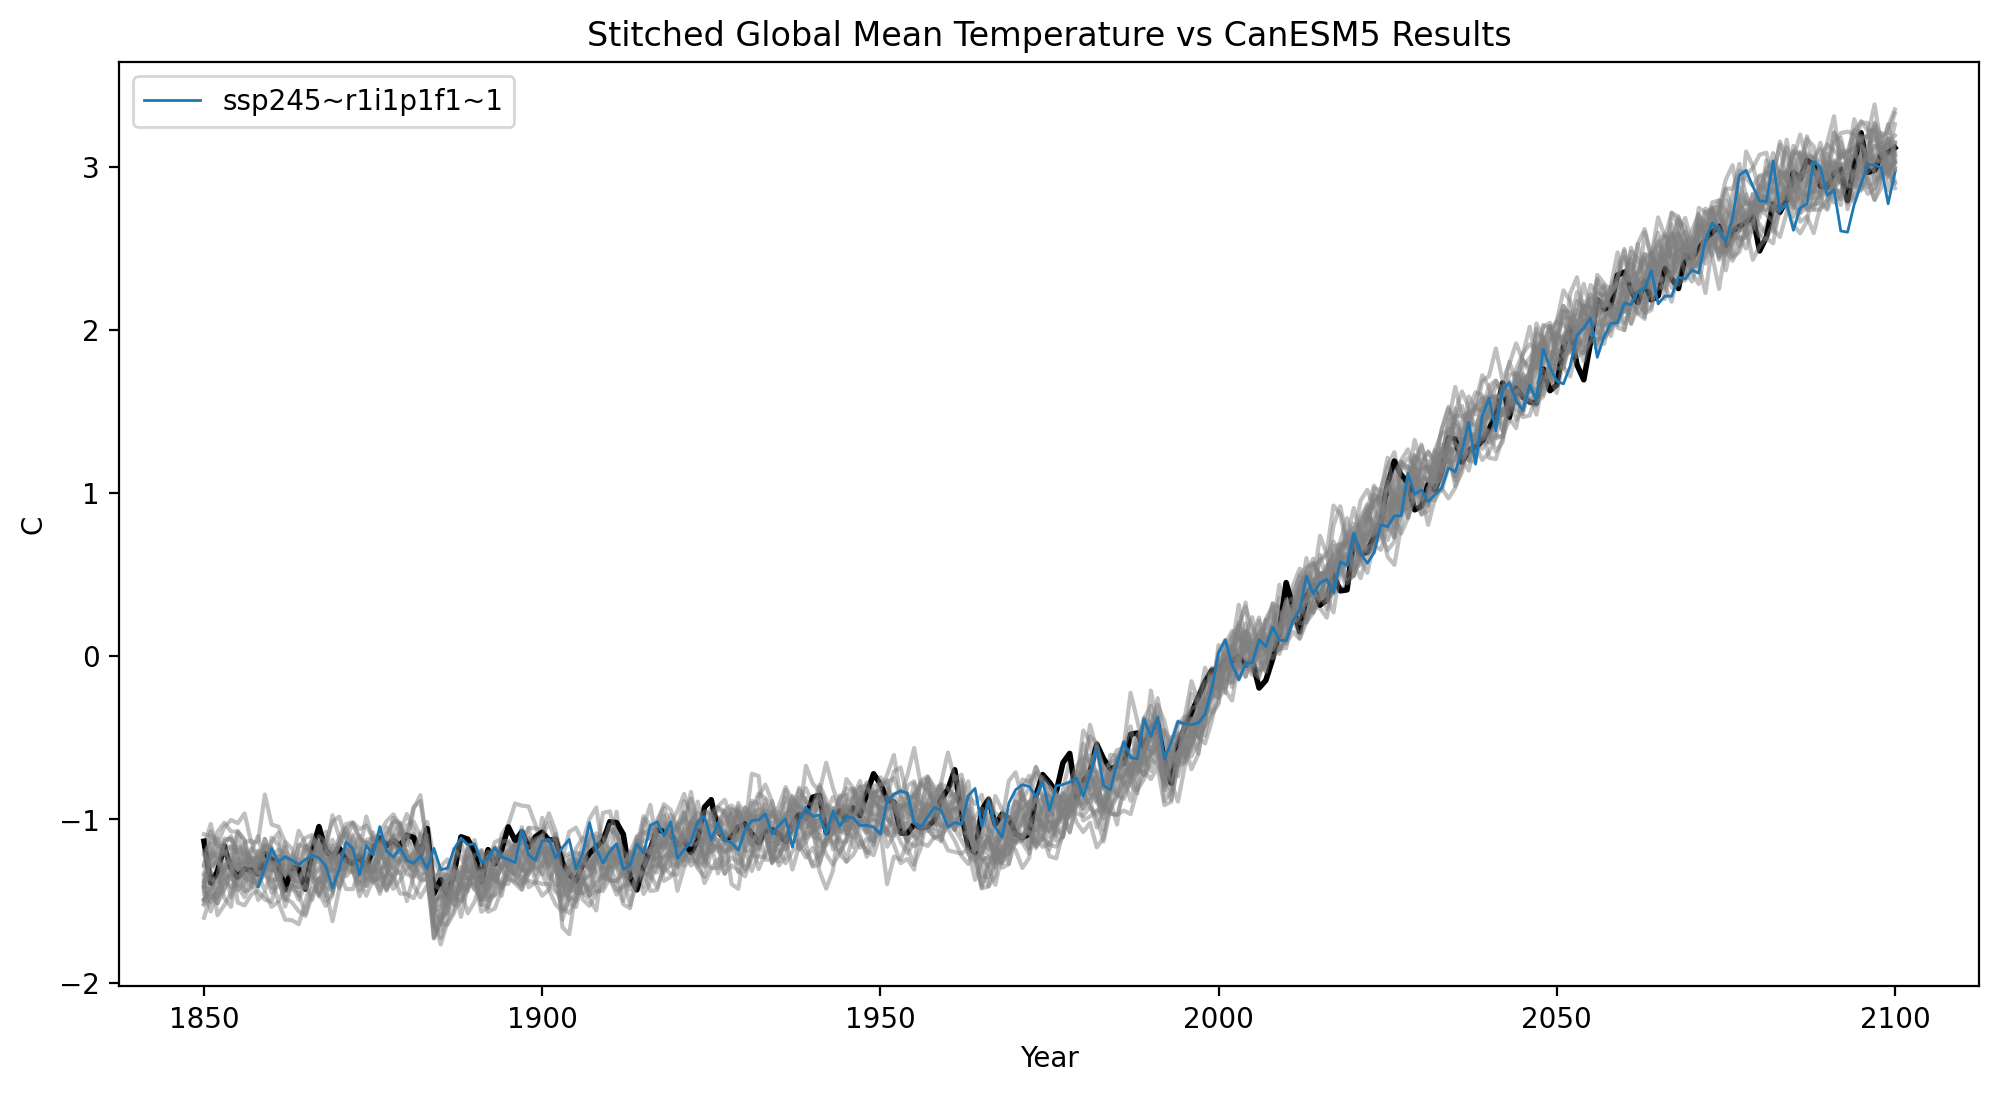

In [14]:
# full ensemble of actual ESM runs:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
    else:
        plt.plot(group.year, group.value, color = "0.5", alpha=0.5)

# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()
plt.close()

# gridded stitching of the non-NN recipes

This takes a few minutes per stitched multivariable realization,
but it will create the netcdfs according to our stitched recipes
that we can load in and work with.

In [ ]:
stitches.gridded_stitching(out_dir='.',  rp=my_recipes)

['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~1']
['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~2']
['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~3']


now you have created multiple gridded, monthly tas and pr files that are
statistically consistent with the target: SSP245 realization 1.

In [ ]:
import xarray as xr

gen_tas = xr.open_dataset('stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc')
gen_tas


In [ ]:
gen_pr = xr.open_dataset('stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc')
gen_pr


# Pull comparison netcdfs

In [ ]:
# Fetch the actual data directly from pangeo
data_directory = pkg_resources.resource_filename("stitches", "data")
pangeo_path = os.path.join(data_directory, "pangeo_table.csv")

pangeo_data = pd.read_csv(pangeo_path)

pangeo_data = pangeo_data.loc[(pangeo_data['variable'].isin(['tas', 'pr']))
                              & (pangeo_data['domain'].str.contains('mon'))
                              & (pangeo_data['experiment'].isin(['ssp245']))
                              & (pangeo_data['ensemble'].isin(['r1i1p1f1']))
                              & (pangeo_data['model'].isin(['CanESM5']))].copy()

# load the target tas netcdf files
tas_address = pangeo_data.loc[pangeo_data['variable']== 'tas'].zstore.copy()
tar_tas = stitches.fetch_nc(tas_address.values[0])

# load the target pr netcdf files
pr_address = pangeo_data.loc[pangeo_data['variable']== 'pr'].zstore.copy()
tar_pr = stitches.fetch_nc(pr_address.values[0])


# Visualize

Select a grid cell and plot the generated and target tas, pr data for first-cut comparison

In [ ]:
# define a helper function
def plot_comparison(generated_data,
                    target_data,
                    variable,
                    alpha=0.8):
    """Plot comparision between target variable time series and generated data"""

    if variable.casefold() == "pr":
        variable_name = "precipitation"
        units = "kg m-2 s-1"
    else:
        variable_name = "temperature"
        units = "C"

    # temperature (tas)
    plt.plot(generated_data.time,
             generated_data[variable],
             label=f"Generated monthly {variable}")

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        plt.plot(target_data.indexes['time'].to_datetimeindex(),
                 target_data[variable],
                 alpha=alpha,
                 label = f"Target monthly {variable}")

    plt.legend()
    plt.xlabel("Year")
    plt.ylabel(units)
    plt.title(f"Actual and generated monthly {variable_name} ({variable})")
    plt.show()
    plt.close()


# lon and lat values for a grid cell near the Joint Global Change Research Institute in College Park, MD, USA
cp_lat = 38.9897
cp_lon = 180 + 76.9378

# lat and lon coordinates closest
abslat = np.abs(gen_tas.lat - cp_lat)
abslon = np.abs(gen_tas.lon-cp_lon)
c = np.maximum(abslon, abslat)
([lon_loc], [lat_loc]) = np.where(c == np.min(c))
lon_grid = gen_tas.lon[lon_loc]
lat_grid = gen_tas.lat[lat_loc]

cp_tas_gen = gen_tas.sel(lon=lon_grid,
                         lat=lat_grid,
                         time=slice('2015-01-01', '2099-12-31')).copy()

cp_tas_tar = tar_tas.sel(lon=lon_grid,
                         lat=lat_grid,
                         time=slice('2015-01-01', '2099-12-31')).copy()

cp_pr_gen = gen_pr.sel(lon=lon_grid,
                       lat=lat_grid,
                       time=slice('2015-01-01', '2099-12-31')).copy()

cp_pr_tar = tar_pr.sel(lon=lon_grid,
                       lat=lat_grid,
                       time=slice('2015-01-01', '2099-12-31')).copy()

# temperature (tas)
plot_comparison(generated_data=cp_tas_gen,
                target_data=cp_tas_tar,
                variable="tas")

# precipitation (pr)
plot_comparison(generated_data=cp_pr_gen,
                target_data=cp_pr_tar,
                variable="pr")

Visual validation of the complex spatial, temporal, and cross-variable
relationships present in ESM outputs is not possible. We extensively validate
that the method reproduces ESM internal variability in the ESD paper, but this
visual plotting at least suggests that nothing is obviously wrong. In particular,
there are no obvious artifacts occurring every 9-years in the generated time
series.


In other words, it's not inconceivable from these plots that the orange time
series were sampled from the same underlying multivariate distribution that
generated the blue time series.